# Timeseries classification with a Transformer model

**Author:** [Theodoros Ntakouris](https://github.com/ntakouris)<br>
**Replication:** [mxochicale](https://github.com/mxochicale/)<br>
**Date created:** 2021/06/25<br>
**Description:** This notebook demonstrates how to do timeseries classification using a Transformer model.

**Logs:**
* MX: Fri 21 Jul 2023 # Out of Memory issue
    ```
    # RESOURCE_EXHAUSTED: OOM when allocating tensor with shape[64,500,4,256] and 
    #     type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
    # SOLUTION > Change batch size https://github.com/tensorflow/models/issues/8487                        
    # OOM means out of memory. May be it is using more memory at that time. 
    # Decrease batch_size significantly. I set to 16, then it worked fine
    # >https://stackoverflow.com/questions/49665757
    ```
* MX: Sat 22 Jul 12:05:24 BST 2023 # Adds confusion matrix https://towardsdatascience.com/exploring-confusion-matrix-evolution-on-tensorboard-e66b39f4ac12


## Introduction

This is the Transformer architecture from
[Attention Is All You Need](https://arxiv.org/abs/1706.03762),
applied to timeseries instead of natural language.

This example requires TensorFlow 2.4 or higher.

## Load the dataset

We are going to use the same dataset and preprocessing as the
[TimeSeries Classification from Scratch](https://keras.io/examples/timeseries/timeseries_classification_from_scratch)
example.

In [ ]:
import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# import numpy as np
# import matplotlib.pyplot as plt
# import itertools
# import sklearn.metrics



: 

In [6]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

print(f'{x_train.shape}, {y_train.shape}')
print(f'{x_test.shape}, {y_test.shape}')

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

print(f'x_train.shape: {x_train.shape}, y_train.shape: {y_train.shape}')
print(f'x_test.shape: {x_test.shape}, y_test.shape: {y_test.shape}')

n_classes = len(np.unique(y_train))
print(f'n_classes: {n_classes}')

# Randomise samples 
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

# Rename labels 
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

print(y_train.shape)
print(y_test.shape)

(3601, 500), (3601,)
(1320, 500), (1320,)
x_train.shape: (3601, 500, 1), y_train.shape: (3601,)
x_test.shape: (1320, 500, 1), y_test.shape: (1320,)
n_classes: 2
(3601,)
(1320,)


In [7]:
## Reducing train and test data size

lenght_of_time_series=450 # Original size # 500
train_size=3500 # Original size # 3601
print(type(x_train))
print(x_train.shape)
x_train = np.resize(x_train, (train_size,lenght_of_time_series))
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)

print(y_train.shape)
y_train = np.resize(y_train, (train_size,))
print(y_train.shape)

test_size = 1200 # Original size #1320
print(type(x_test))
print(x_test.shape)
x_test = np.resize(x_test, (test_size,lenght_of_time_series))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

print(x_test.shape)

print(y_test.shape)
y_test = np.resize(y_test, (test_size,))
print(y_test.shape)


<class 'numpy.ndarray'>
(3601, 500, 1)
(3500, 450, 1)
(3601,)
(3500,)
<class 'numpy.ndarray'>
(1320, 500, 1)
(1200, 450, 1)
(1320,)
(1200,)


## Visualize the data

Here we visualize one timeseries example for each class in the dataset.

idx: 700
    class 0 with c_x_train.shape (1793, 450, 1)


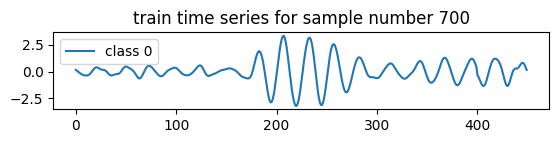

    class 1 with c_x_train.shape (1707, 450, 1)


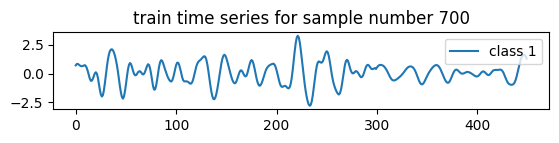

In [9]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

start_sample_numbers=700
end_interval=1

for idx in range(start_sample_numbers,start_sample_numbers+end_interval):
    print(f'idx: {idx}')    
    
    for c in classes:
        c_x_train = x_train[y_train == c]
        print(f'    class {c} with c_x_train.shape {c_x_train.shape}')
        plt.figure().set_figheight(1)
        plt.plot(c_x_train[idx], label="class " + str(c))
        plt.legend(loc="best")
        plt.title(f'train time series for sample number {idx}')
        plt.show()
        plt.close()
    plt.close()

## Build the model

Our model processes a tensor of shape `(batch size, sequence length, features)`,
where `sequence length` is the number of time steps and `features` is each input
timeseries.

You can replace your classification RNN layers with this one: the
inputs are fully compatible!

We include residual connections, layer normalization, and dropout.
The resulting layer can be stacked multiple times.

The projection layers are implemented through `keras.layers.Conv1D`.

In [10]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


The main part of our model is now complete. We can stack multiple of those
`transformer_encoder` blocks and we can also proceed to add the final
Multi-Layer Perceptron classification head. Apart from a stack of `Dense`
layers, we need to reduce the output tensor of the `TransformerEncoder` part of
our model down to a vector of features for each data point in the current
batch. A common way to achieve this is to use a pooling layer. For
this example, a `GlobalAveragePooling1D` layer is sufficient.

In [11]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
    ):
    
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    
    return keras.Model(inputs, outputs)


## Setup model

In [12]:
input_shape = x_train.shape[1:]

epoch_number = 2
# epoch_number = 10
#epoch_number = 25
# epoch_number = 50
# epoch_number = 100
# epoch_number = 200
# epoch_number = 300
# epoch_number = 500

batch_size = 16
# batch_size = 32
# batch_size = 64 #< OOM


## Transformer settings 
# head_size=256; num_heads=4; num_transformer_blocks = 4
# head_size=256; num_heads=4; num_transformer_blocks = 8
head_size=512; num_heads=4; num_transformer_blocks = 4
# head_size=1024; num_heads=4; num_transformer_blocks = 4
# head_size=1024; num_heads=8; num_transformer_blocks = 8


model = build_model(
    input_shape,
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=4,
    num_transformer_blocks=num_transformer_blocks,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("best_transforer_model.h5", save_best_only=True, monitor="val_loss"),
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]

#other callbacks
#     keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001),
#     keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),

print(f'input_shape: {input_shape}')


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 450, 1)]             0         []                            
                                                                                                  
 layer_normalization (Layer  (None, 450, 1)               2         ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention (Mult  (None, 450, 1)               14337     ['layer_normalization[0][0]', 
 iHeadAttention)                                                     'layer_normalization[0][0]'] 
                                                                                              

In [13]:
keras.utils.plot_model(model, show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Train the model

In [14]:
# fit network
history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=epoch_number,
    batch_size=batch_size,
    callbacks=callbacks,
)


Epoch 1/2


175/175 [==============================] - 323s 2s/step - loss: 1.0546 - sparse_categorical_accuracy: 0.4989 - val_loss: 0.7938 - val_sparse_categorical_accuracy: 0.5071
Epoch 2/2


/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


175/175 [==============================] - 318s 2s/step - loss: 0.9078 - sparse_categorical_accuracy: 0.5014 - val_loss: 0.7666 - val_sparse_categorical_accuracy: 0.4929


## Plot the model's training and validation loss

history.params: {'verbose': 1, 'epochs': 2, 'steps': 175}
history.history.keys(): dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


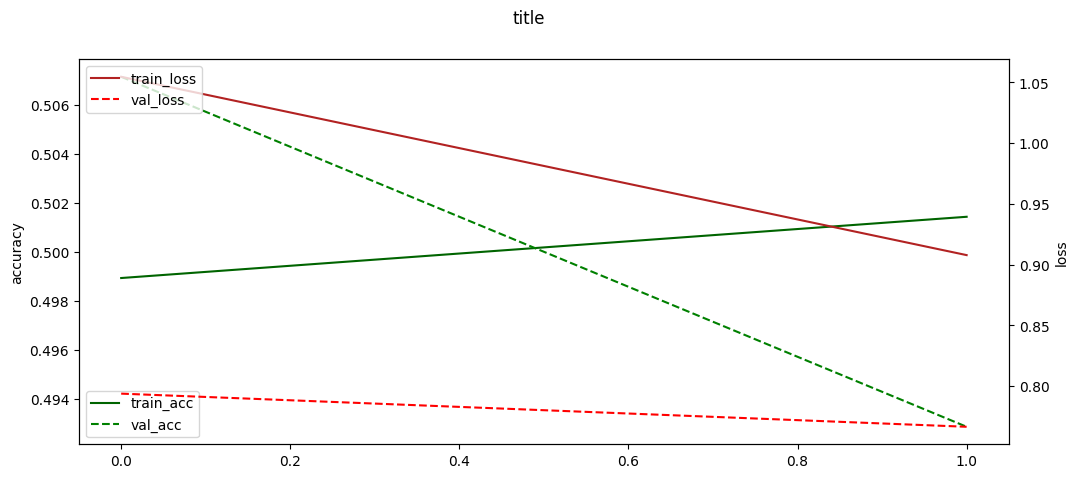

In [16]:
metric = "sparse_categorical_accuracy"

print(f'history.params: {history.params}' )
print(f'history.history.keys(): {history.history.keys()}')

fig = plt.figure(figsize=(12,5))
fig.suptitle("title")
ax1 = fig.add_subplot()
ax2 = ax1.twinx()

ax1.plot(history.history['sparse_categorical_accuracy'], color='darkgreen', label = 'train_acc', linestyle='solid')
ax1.plot(history.history['val_sparse_categorical_accuracy'], color='green', label = 'val_acc',linestyle='--')

ax2.plot(history.history['loss'], color='firebrick', label = 'train_loss', linestyle='solid')
ax2.plot(history.history['val_loss'], color='red', label = 'val_loss',linestyle='--')

ax1.set_ylabel("accuracy")
ax2.set_ylabel("loss")

ax1.legend(loc = 'lower left')
ax2.legend(loc = 'upper left')

plt.show()


## Evaluate model on test data

In [17]:
loaded_model = keras.models.load_model("best_transforer_model.h5")
test_loss, test_acc = loaded_model.evaluate(x_test, 
                                            y_test, 
                                            batch_size=batch_size,
                                            verbose=1)

print(f'=============================')
print(f'=============================')
print(f'Test accuracy {test_acc*100} and Test loss {test_loss*100}')
print(f'=============================')
print(f'=============================')

75/75 [==============================] - 47s 622ms/step - loss: 0.7665 - sparse_categorical_accuracy: 0.4967
Test accuracy 49.666666984558105 and Test loss 76.6522228717804


In [18]:
#Understanding your h5 model > https://www.youtube.com/watch?v=_a-UYLfF6TE
print(loaded_model.summary())
# for layer in loaded_model.layers:
    # print(layer.name)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 450, 1)]             0         []                            
                                                                                                  
 layer_normalization (Layer  (None, 450, 1)               2         ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention (Mult  (None, 450, 1)               14337     ['layer_normalization[0][0]', 
 iHeadAttention)                                                     'layer_normalization[0][0]'] 
                                                                                              

In [19]:
## Load model
predictions = loaded_model.predict(x_test)


38/38 [==============================] - 47s 1s/step


x_test.shape: (1200, 450, 1), predictions.shape:  (1200, 2)
Ground truth for test timeseries:  1
Predictions for each class:

class: 0  probability:  0.35198963
class: 1  probability:  0.6480103
len(predicted_labels): 1200
[1 0 0 ... 1 1 0]
[0 0 0 ... 0 0 0]


Text(0.5, 55.65546539603249, 'Predicted label')

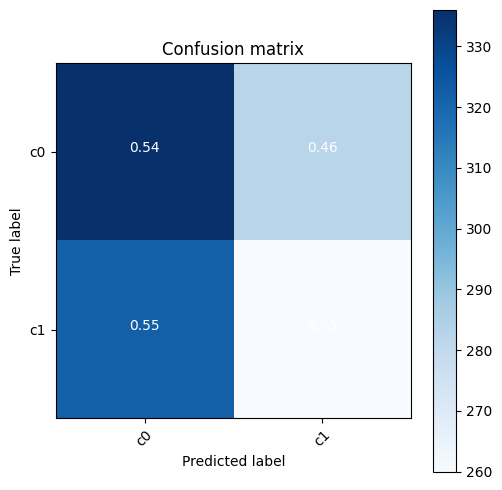

In [20]:
print(f'x_test.shape: {x_test.shape}, predictions.shape:  {predictions.shape}')

index = 100 # up to 9999
print('Ground truth for test timeseries: ',y_test[index])
print('Predictions for each class:\n')
for i in range(2):
    print('class:', i, ' probability: ', predictions[index][i])

# For each sample timeseries in the test dataset, select the class label with the highest probability.
predicted_labels = [np.argmax(i) for i in predictions]
print(f'len(predicted_labels): {len(predicted_labels)}')


test_pred = np.argmax(predictions, axis=1)
print(test_pred)
print(y_test)

# cm = sklearn.metrics.confusion_matrix(y_test, test_pred)
cm = sklearn.metrics.confusion_matrix(y_test, test_pred)


class_names = ['c0', 'c1']

figure = plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Normalize the confusion matrix.
cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
# Use white text if squares are dark; otherwise black.
threshold = cm.max() / 2.

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')



## Conclusions

In about 110-120 epochs (25s each on Colab), the model reaches a training
accuracy of ~0.95, validation accuracy of ~84 and a testing
accuracy of ~85, without hyperparameter tuning. And that is for a model
with less than 100k parameters. Of course, parameter count and accuracy could be
improved by a hyperparameter search and a more sophisticated learning rate
schedule, or a different optimizer.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/timeseries_transformer_classification) and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/timeseries_transformer_classification).